In [5]:
import pandas as pd


url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" \
                "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"


df_confirmed = pd.read_csv(url_confirmed)

print(f"Dataset shape: {df_confirmed.shape}")
df_confirmed.head()


Dataset shape: (289, 1147)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


2. parsing

In [8]:
# Melt the dataframe to long format (tidy data)
df_long = df_confirmed.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
    var_name='Date',
    value_name='ConfirmedCases'
)

# Convert 'Date' column to datetime with explicit format to avoid warnings
df_long['Date'] = pd.to_datetime(df_long['Date'], format='%m/%d/%y')

# Rename columns for consistency
df_long.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'}, inplace=True)

# Check for missing values
print(f"Missing values:\n{df_long.isnull().sum()}")

# Fill missing Province with 'None' for clarity
df_long['Province'] = df_long['Province'].fillna('None')

df_long.head(3)



Missing values:
Province          226314
Country                0
Lat                 2286
Long                2286
Date                   0
ConfirmedCases         0
dtype: int64


,Province,Country,Lat,Long,Date,ConfirmedCases
0,None,Afghanistan,33.93911,67.709953,2020-01-22,0
1,None,Albania,41.15330,20.168300,2020-01-22,0
2,None,Algeria,28.03390,1.659600,2020-01-22,0


3. Filter

In [9]:
# Get latest date in dataset
latest_date = df_long['Date'].max()
print(f"Latest date in dataset: {latest_date.date()}")

# Aggregate cases by country on latest date
latest_data = df_long[df_long['Date'] == latest_date].groupby('Country')['ConfirmedCases'].sum().sort_values(ascending=False)

# top 5 countries
top5_countries = latest_data.head(5).index.tolist()
print("Top 5 countries by confirmed cases:", top5_countries)

# Filter dataset for these countries
df_filtered = df_long[df_long['Country'].isin(top5_countries)]
df_filtered.head(3)


Latest date in dataset: 2023-03-09
Top 5 countries by confirmed cases: ['US', 'India', 'France', 'Germany', 'Brazil']


,Province,Country,Lat,Long,Date,ConfirmedCases
31,None,Brazil,-14.2350,-51.9253,2020-01-22,0
120,French Guiana,France,3.9339,-53.1258,2020-01-22,0
121,French Polynesia,France,-17.6797,149.4068,2020-01-22,0


4. Mine

In [10]:
# Sort values to compute differences correctly
df_filtered = df_filtered.sort_values(['Country', 'Date'])

# Calculate daily new cases per country
df_filtered['DailyNewCases'] = df_filtered.groupby('Country')['ConfirmedCases'].diff().fillna(0)

# Replace negative values (data corrections) with 0
df_filtered['DailyNewCases'] = df_filtered['DailyNewCases'].clip(lower=0)

# Calculate 7-day rolling average of daily new cases
df_filtered['7DayAvgNewCases'] = df_filtered.groupby('Country')['DailyNewCases'].transform(lambda x: x.rolling(window=7).mean())

# Display summary statistics of daily new cases for top countries
stats = df_filtered.groupby('Country')['DailyNewCases'].describe()[['mean', 'std', 'min', 'max']]
print(stats)


                 mean           std  min         max
Country                                             
Brazil   3.246025e+04  3.461306e+04  0.0    287149.0
France   1.153196e+06  5.568564e+06  0.0  38615082.0
Germany  3.346374e+04  6.467254e+04  0.0    484345.0
India    3.910228e+04  7.163087e+04  0.0    414188.0
US       9.081939e+04  1.265446e+05  0.0   1354505.0


5. Represent


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set seaborn style for plots
sns.set(style='whitegrid')


a) Line chart: 7-day average daily new cases over time per country

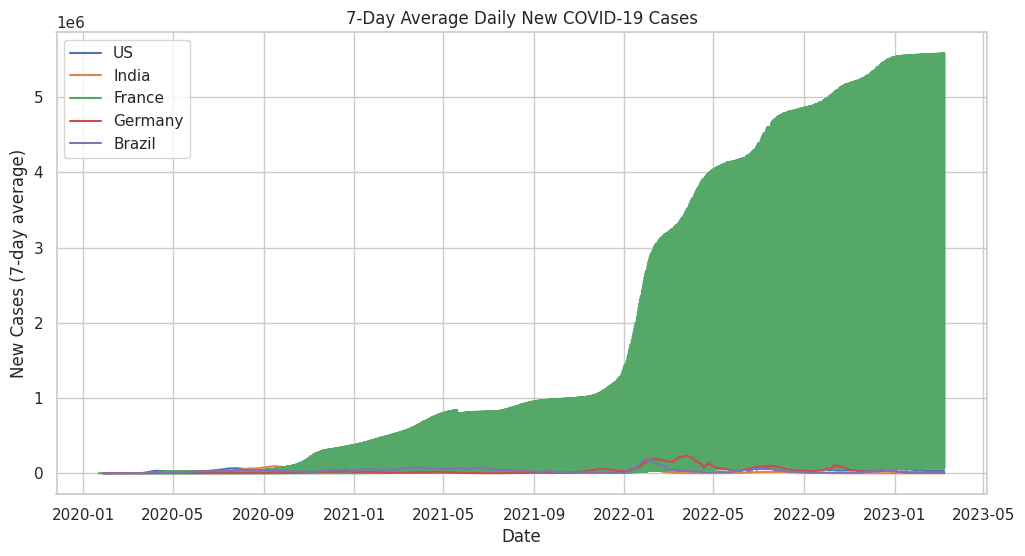

In [15]:
plt.figure(figsize=(12, 6))
for country in top5_countries:
    subset = df_filtered[df_filtered['Country'] == country]
    plt.plot(subset['Date'], subset['7DayAvgNewCases'], label=country)

plt.title('7-Day Average Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases (7-day average)')
plt.legend()
plt.show()


b) Heatmap: Correlation of daily new cases between top countries

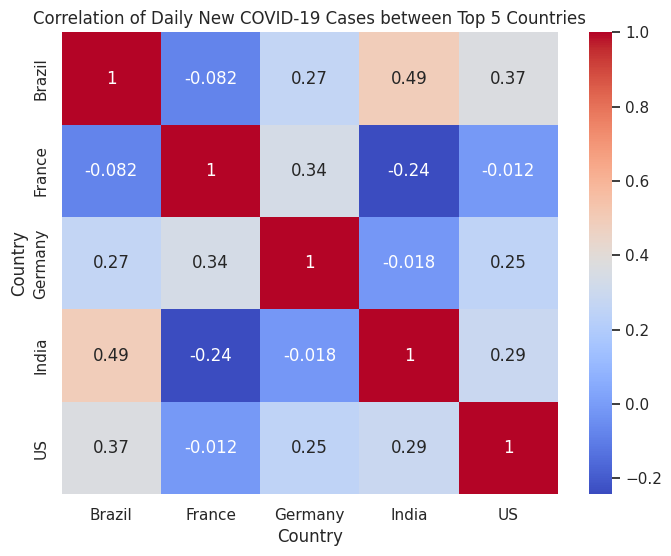

In [18]:
# Aggregate to get total daily new cases per country
agg_df = df_filtered.groupby(['Date', 'Country'])['DailyNewCases'].sum().reset_index()

# Now pivot safely
pivot_df = agg_df.pivot(index='Date', columns='Country', values='DailyNewCases').fillna(0)

# Plot heatmap of correlations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(pivot_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Daily New COVID-19 Cases between Top 5 Countries')
plt.show()


 Interactive scatter plot of Daily New Cases vs. Confirmed Cases

In [19]:
fig = px.scatter(df_filtered, x='ConfirmedCases', y='DailyNewCases', color='Country',
                 hover_name='Country', animation_frame=df_filtered['Date'].dt.strftime('%Y-%m-%d'),
                 title='Daily New Cases vs. Total Confirmed Cases Over Time',
                 labels={'ConfirmedCases': 'Total Confirmed Cases', 'DailyNewCases': 'Daily New Cases'})
fig.show()


6. Refine

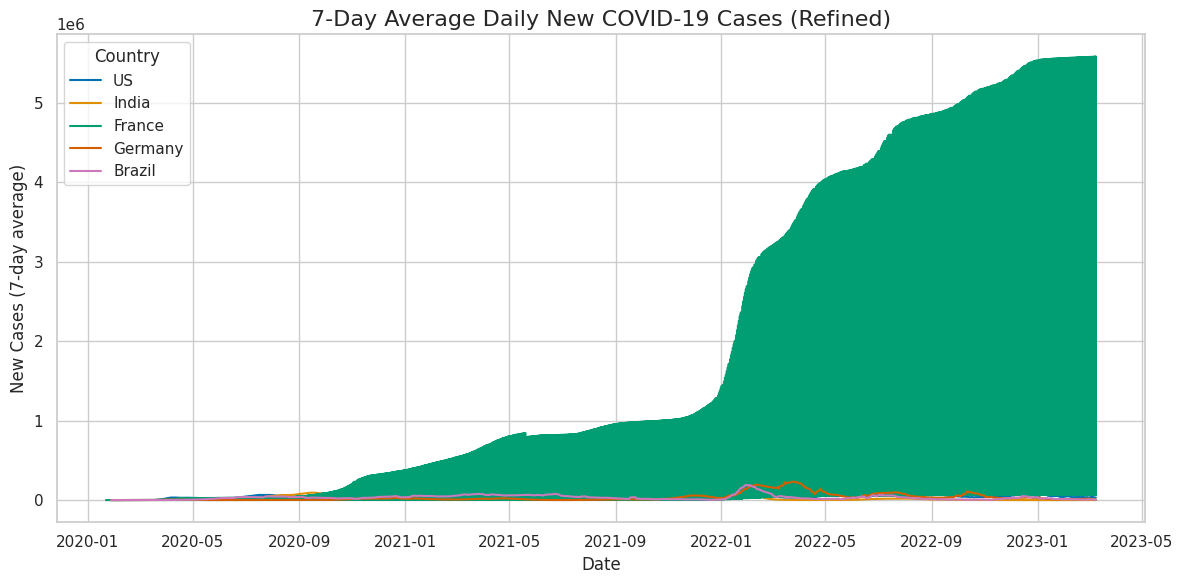

In [20]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("colorblind", n_colors=len(top5_countries))
for i, country in enumerate(top5_countries):
    subset = df_filtered[df_filtered['Country'] == country]
    plt.plot(subset['Date'], subset['7DayAvgNewCases'], label=country, color=palette[i])

plt.title('7-Day Average Daily New COVID-19 Cases (Refined)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('New Cases (7-day average)', fontsize=12)
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()


7. Interact
Add basic interactivity (e.g., using widgets, plotly, or interactive matplotlib).
Users should be able to explore different subsets or variables.

In [21]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for countries
country_dropdown = widgets.SelectMultiple(
    options=top5_countries,
    value=top5_countries,
    description='Countries',
    disabled=False
)

def plot_interactive(selected_countries):
    plt.figure(figsize=(12,6))
    for country in selected_countries:
        subset = df_filtered[df_filtered['Country'] == country]
        plt.plot(subset['Date'], subset['7DayAvgNewCases'], label=country)
    plt.title('7-Day Average Daily New COVID-19 Cases (Interactive)')
    plt.xlabel('Date')
    plt.ylabel('New Cases (7-day average)')
    plt.legend()
    plt.grid(True)
    plt.show()

widgets.interact(plot_interactive, selected_countries=country_dropdown)


interactive(children=(SelectMultiple(description='Countries', index=(0, 1, 2, 3, 4), options=('US', 'India', '…

<function __main__.plot_interactive(selected_countries)>